In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px 
import numpy as np
import os
import random

# from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split

import glob

# Neural Network imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam


# Image augmentation importrs
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.layers import RandomContrast
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.layers import RandomFlip
from tensorflow.keras.layers import RandomTranslation

# Training Model callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

# # Check if GPU is available
# print(f'Tensorflow Version: {tf.__version__}')
# print("GPU Available:", tf.config.list_physical_devices('GPU')[0])

SEED = 42


# Data Visualization updates

%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (16, 10)
plt.rcParams.update({'font.size': 14})


In [54]:
import os

# Get the current working directory
current_dir = os.getcwd()

# Join the current directory with the desired path
target_dir_train = os.path.join(current_dir, 'MRNet-v1.0', 'train', 'axial')
target_dir_valid= os.path.join(current_dir, 'MRNet-v1.0', 'valid', 'axial')


In [55]:
def get_data_labels(directory, random_state=42, test_size=0.2):
    """
    Load data and labels from the given directory and split into train and test sets.
    
    Args:
    - directory: The path to the directory containing class subdirectories.
    - random_state: Seed for random number generator.
    - test_size: Fraction of the dataset to include in the test split.

    Returns:
    - train_paths, train_labels, test_paths, test_labels
    """
    class_mappings = {'Glioma': 0, 'Meninigioma': 1, 'Notumor': 2, 'Pituitary': 3}
    all_paths = []
    all_labels = []

    for class_name, label in class_mappings.items():
        class_dir = os.path.join(directory, class_name)
        class_files = glob(os.path.join(class_dir, '*.npy'))
        
        all_paths.extend(class_files)
        all_labels.extend([label] * len(class_files))

    # Split into train and test
    train_paths, test_paths, train_labels, test_labels = train_test_split(
        all_paths, all_labels, test_size=test_size, random_state=random_state, stratify=all_labels
    )

    return train_paths, train_labels, test_paths, test_labels

In [56]:
def get_dataset(image_paths, image_labels, image_dim, n_channels, num_classes, batch_size):
    """
    Creates a TensorFlow dataset for loading, preprocessing, and batching images.

    Parameters:
    - image_paths: List of file paths to the .npy files.
    - image_labels: Corresponding labels for each .npy file.
    - image_dim: Tuple, dimensions to resize images (height, width).
    - n_channels: Number of channels (1 for grayscale).
    - num_classes: Number of classes for classification.
    - batch_size: Number of samples per batch.

    Returns:
    - A tf.data.Dataset object for the specified dataset.
    """
    # Define a function to preprocess each image stack
    def preprocess_image(file_path, label):
        # Load the .npy file
        img_array = np.load(file_path.decode('utf-8'))  # Decode from bytes to string for numpy loading
        
        # Check if the images need reshaping
        if img_array.shape[-1] != n_channels:
            img_array = np.expand_dims(img_array, axis=-1)  # Expand dimensions if necessary
        
        # Resize each image in the stack
        img_array = tf.image.resize(img_array, image_dim)
        
        # Normalize the image stack to [0, 1]
        img_array = tf.cast(img_array, tf.float32) / 255.0

        # One-hot encode the label if needed
        label = tf.one_hot(label, num_classes)

        return img_array, label

    # Create a TensorFlow Dataset from the file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, image_labels))

    # Apply preprocessing to each image
    dataset = dataset.map(lambda file_path, label: tf.py_function(
        preprocess_image, [file_path, label], [tf.float32, tf.float32]), num_parallel_calls=tf.data.AUTOTUNE)

    # Shuffle, batch, and prefetch the dataset for performance optimization
    dataset = dataset.shuffle(buffer_size=len(image_paths))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
train_paths, train_index = get_data_labels(target_dir_train, random_state=SEED)
test_paths, test_index = get_data_labels(target_dir_valid, random_state=SEED)

# Printing traing and testing sample sizes

print('Training')
print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_index)}')
print('\nTesting')
print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_index)}')

# Prepare datasets with 4 classes and grayscale
batch_size = 32
image_dim = (44, 256, 256)
train_ds = get_dataset(train_paths, train_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)

test_ds = get_dataset(test_paths, test_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)

# Output to show datasets
print(f"\nTraining dataset: {train_ds}")
print(f"\nTesting dataset: {test_ds}")

# Class mappings
class_mappings = {'axial': 0, 'coronal': 1, 'sagittal': 2}
inv_class_mappings = {v: k for k, v in class_mappings.items()}
class_names = list(class_mappings.keys())




NameError: name 'train_test_split' is not defined

Sample of train_index: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Sample of test_index: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


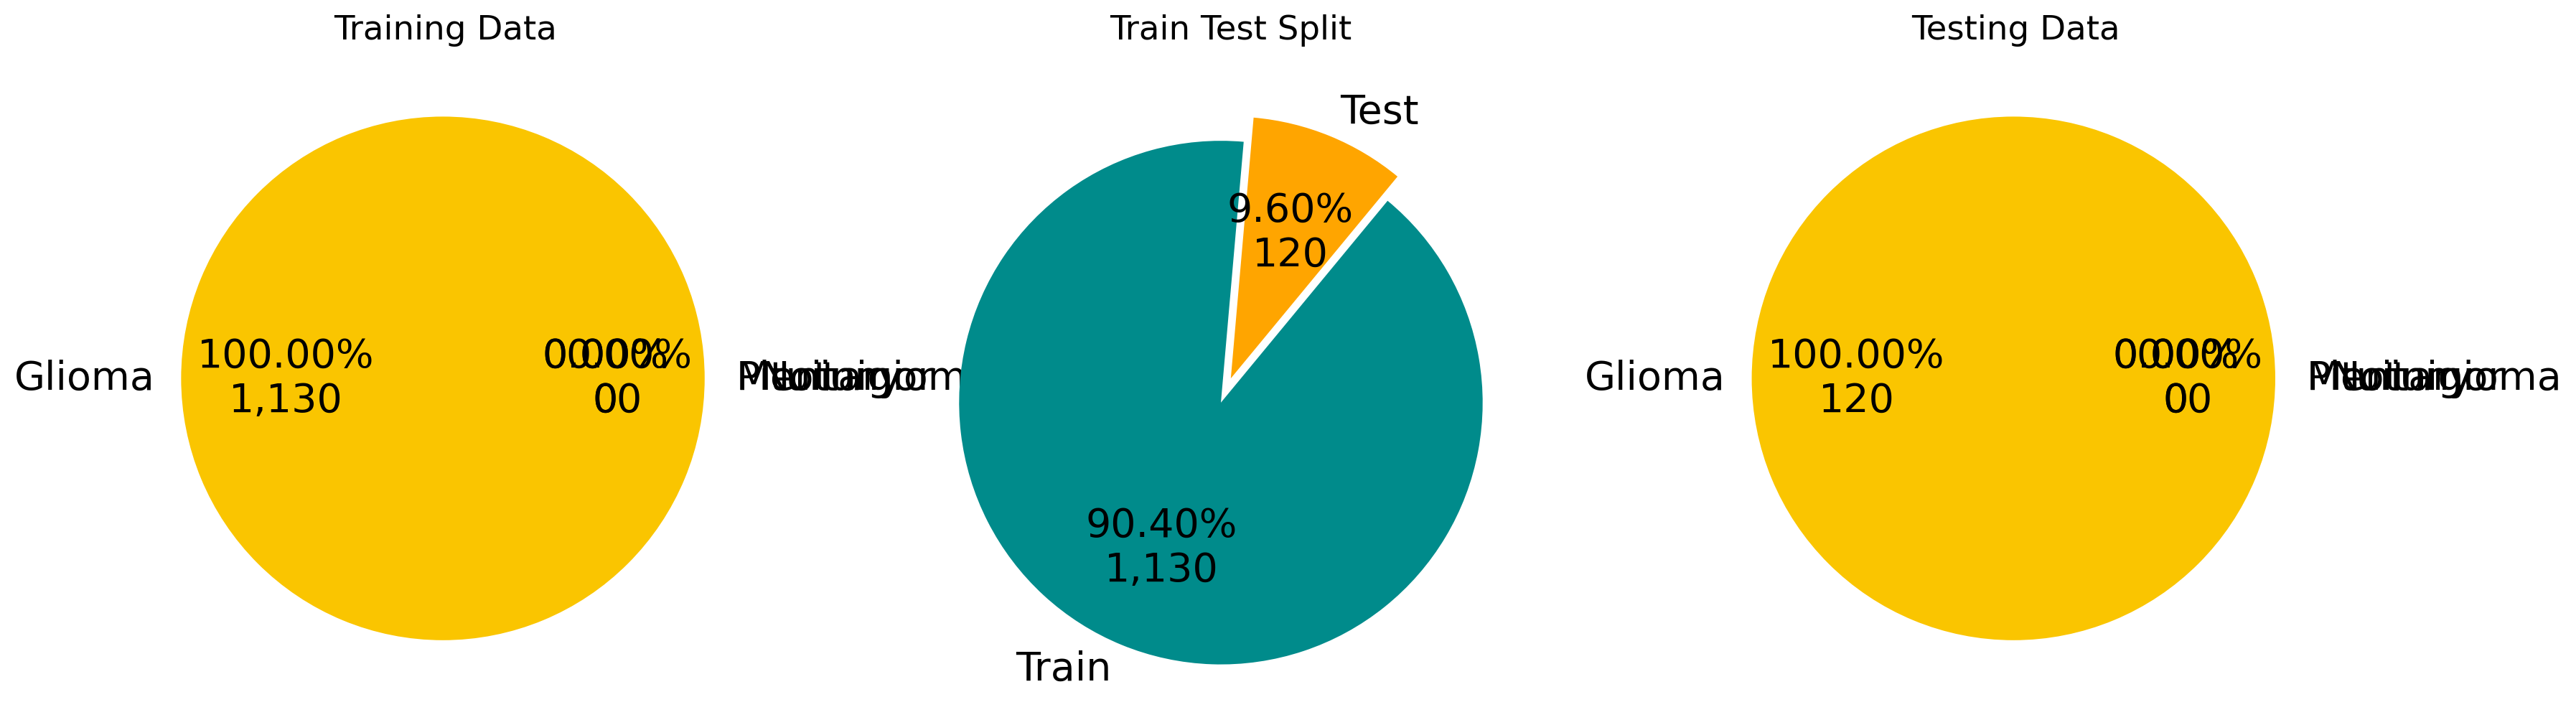

In [ ]:
import matplotlib.pyplot as plt

# Ensure class_names, train_index, and test_index are defined
class_names = ['axial', 'coronal', 'sagittal']
# Debugging: Verify the contents of train_index and test_index
print(f"Sample of train_index: {train_index[:10]}")
print(f"Sample of test_index: {test_index[:10]}")

_, ax = plt.subplots(ncols=3, figsize=(20, 14))

# Plotting training data types
train_class_counts = [len([x for x in train_index if x == class_mappings[label]]) for label in class_names]
if sum(train_class_counts) > 0:  # Ensure there is at least one non-zero value
    ax[0].set_title('Training Data')
    ax[0].pie(
        train_class_counts,
        labels=class_names,  # Ensure labels match the number of data points
        colors=['#FAC500','#0BFA00', '#0066FA','#FA0000'], 
        autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(train_class_counts) / 100),
        explode=(0.01, 0.01, 0.1, 0.01),
        textprops={'fontsize': 20}
    )
else:
    print("Warning: Training data contains no samples.")

# Plotting distribution of train test split
train_count = len(train_index)
test_count = len(test_index)
if train_count + test_count > 0:  # Ensure there is at least one non-zero value
    ax[1].set_title('Train Test Split')
    ax[1].pie(
        [train_count, test_count],
        labels=['Train','Test'],
        colors=['darkcyan', 'orange'], 
        autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * (train_count + test_count) / 100),
        explode=(0.1, 0),
        startangle=85,
        textprops={'fontsize': 20}
    )
else:
    print("Warning: No data for train-test split.")

# Plotting testing data types
test_class_counts = [len([x for x in test_index if x == class_mappings[label]]) for label in class_names]
if sum(test_class_counts) > 0:  # Ensure there is at least one non-zero value
    ax[2].set_title('Testing Data')
    ax[2].pie(
        test_class_counts,
        labels=class_names,  # Ensure labels match the number of data points
        colors=['#FAC500', '#0BFA00', '#0066FA', '#FA0000'],
        autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(test_class_counts) / 100),
        explode=(0.01, 0.01, 0.1, 0.01),
        textprops={'fontsize': 20} 
    )
else:
    print("Warning: Testing data contains no samples.")

plt.show()


In [ ]:
def get_data_labels(data_dir, random_state=None):
    """
    Obtém os caminhos dos arquivos .npy e os rótulos de um diretório de dados.
    
    Args:
    - data_dir (str): Caminho para o diretório de dados contendo arquivos .npy.
    - random_state (int, optional): Semente para randomização.

    Returns:
    - paths (list): Lista de caminhos dos arquivos .npy.
    - labels (list): Lista de rótulos correspondentes.
    """
    if random_state is not None:
        random.seed(random_state)

    paths = []
    labels = []

    # Verifique se o diretório existe
    if not os.path.exists(data_dir):
        print(f"Diretório não encontrado: {data_dir}")
        return paths, labels

    # Lista de arquivos .npy diretamente no diretório de dados
    npy_files = [file_name for file_name in os.listdir(data_dir) if file_name.endswith('.npy')]
    
    if not npy_files:
        print(f"Sem arquivos .npy encontrados no diretório: {data_dir}")
        return paths, labels

    # Como não há subdiretórios, assumimos que todos os arquivos têm o mesmo rótulo
    label = 0  # Pode-se ajustar isso conforme necessário

    for npy_name in npy_files:
        npy_path = os.path.join(data_dir, npy_name)
        paths.append(npy_path)
        labels.append(label)

    if not paths:
        print("Nenhum arquivo .npy encontrado no diretório de dados.")
        return paths, labels

    # Embaralhe os dados se necessário
    combined = list(zip(paths, labels))
    random.shuffle(combined)
    paths, labels = zip(*combined) if combined else ([], [])

    return list(paths), list(labels)

In [ ]:
from collections import Counter

train_label_counts = Counter(train_index)
test_label_counts = Counter(test_index)

print("Training Label Distribution:", train_label_counts)
print("Testing Label Distribution:", test_label_counts)

# Further investigation
print("\nInspecting a few training paths and their labels:")
for path, label in zip(train_paths[:100], train_index[:100]):
    print(f"Path: {path}, Label: {label}")

print("\nInspecting a few testing paths and their labels:")
for path, label in zip(test_paths[:100], test_index[:100]):
    print(f"Path: {path}, Label: {label}")

Training Label Distribution: Counter({0: 1130})
Testing Label Distribution: Counter({0: 120})

Inspecting a few training paths and their labels:
Path: e:\workspace\PythonProjects\trincas-2unidade\MRNet-v1.0\train\axial\0493.npy, Label: 0
Path: e:\workspace\PythonProjects\trincas-2unidade\MRNet-v1.0\train\axial\1045.npy, Label: 0
Path: e:\workspace\PythonProjects\trincas-2unidade\MRNet-v1.0\train\axial\0213.npy, Label: 0
Path: e:\workspace\PythonProjects\trincas-2unidade\MRNet-v1.0\train\axial\0423.npy, Label: 0
Path: e:\workspace\PythonProjects\trincas-2unidade\MRNet-v1.0\train\axial\0909.npy, Label: 0
Path: e:\workspace\PythonProjects\trincas-2unidade\MRNet-v1.0\train\axial\0395.npy, Label: 0
Path: e:\workspace\PythonProjects\trincas-2unidade\MRNet-v1.0\train\axial\0657.npy, Label: 0
Path: e:\workspace\PythonProjects\trincas-2unidade\MRNet-v1.0\train\axial\0632.npy, Label: 0
Path: e:\workspace\PythonProjects\trincas-2unidade\MRNet-v1.0\train\axial\0401.npy, Label: 0
Path: e:\workspace